# Import Libraries

In [1]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json

# Model

In [2]:
 # Create a model
model = grb.Model("Model")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


# Get data from json

In [3]:
# get the  data from the json file small.json
def get_data(size = 'small'):
    with open(size + '.json') as f:
        data = json.load(f)
    return data
data = get_data()

## Constants from data

In [4]:

horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

    

# Model's parameters

#### Objective 1
H : days

Q : qualifications

S : staff

J : jobs

qi : qualifications of i

qj : qualifications of j

vi : vacation days of i

njk : required work load for j with k

cj : daily penalty of j

gj : gain of j

dj : due date of j

yj : is j completely done

lj : delay in days for j

ej : end date of j

pi_j_k_t : work is done by i with k for j on t

#### Objective 2
aij : j is assigned to i

ni : number of jobs i works on

max_i : max of ni

### Objective 3
sj : start date for j

nj : length in days for j

max_j : maximum of nj

In [5]:
H = [i for i in range(1,horizon+1)]
Q = qualifications
S = staff_names
J = job_list
# Parameters for each staff

qi = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    qi[k] = []
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            qi[k].append(c)
vi={}
for ind,i in enumerate(staff_names):
    vi[i] = []
    for j in jour_list:
        if j in vacation_staff[ind]:
            vi[i].append(j)
#vi=staff_in_vacation.to_dict(orient='index')

# Parameters for each job
qj = dict()
for ind, j in enumerate(job_list):
    qj[j] = list(job_qualifications[ind].keys())
njk = dict(zip(job_list,job_qualifications))
cj=job_penality_dict=dict(zip(job_list,job_penality))
gj=job_gain_dict=dict(zip(job_list,job_gain))
dj = dict(zip(job_list,due_dates))

# Decision variables

In [6]:
# Objective 1
pijkt = model.addVars(staff_names,job_list,qualifications,jour_list, vtype=GRB.BINARY, name="pijkt")

yj = model.addVars(job_list, vtype=GRB.BINARY, name="yj")
lj = model.addVars(job_list, vtype=GRB.INTEGER, name="lj")
ej = model.addVars(job_list, vtype=GRB.INTEGER, name="ej")

# Objective 2
max_i = model.addVar(vtype=GRB.INTEGER, name="max_i")
ni = model.addVars(S, vtype=GRB.INTEGER, name="ni")
aij = model.addVars(S, J, vtype=GRB.BINARY, name="aij")

# Objective 3
sj = model.addVars(J, vtype=GRB.INTEGER, name="sj")
nj = model.addVars(J, vtype=GRB.INTEGER, name="nj")
max_j = model.addVar(vtype=GRB.INTEGER, name="max_j")

# Constraints

### Objective 1 constraints

In [7]:
constr1 = {f'constr1{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) <= 1 , name=f"constr1{i}_{t}")
  for i in S
  for t in H}

constr2 = {f'constr2{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) == 0 , name=f"constr2{i}_{t}")
  for i in S
  for t in vi[i]}

constr3 = {f'constr3{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t] == 0 , name=f"constr3{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q if k not in qj[j] or k not in qi[i]
  for t in H}

constr4 = {f'constr4{j}_{k}': model.addConstr( yj[j]*njk[j][k] <= grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) , name=f"constr4{j}_{k}")
  for j in J
  for k in qj[j]}

constr5 = {f'constr5{j}_{k}': model.addConstr( grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) <= njk[j][k] , name=f"constr5{j}_{k}")
  for j in J
  for k in qj[j]}

constr6 = {f'constr6{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t]*t <= ej[j] , name=f"constr6{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q
  for t in H}

constr7 = {f'constr7{j}' : model.addConstr( ej[j] - dj[j] <= lj[j] , name =f"constr7{j}")
  for j in J}

constr8 = {f'constr8{j}' : model.addConstr( 1 <= ej[j] , name =f"constr8{j}")
  for j in J}

constr9 = {f'constr9{j}' : model.addConstr( ej[j] <= H[-1] , name =f"constr9{j}")
  for j in J}

### Objective 2 constraints

In [8]:
# assigned jobs to a staff member i is aij[i, j]
constr10 = {f'constr10{i}_{j}_{k}_{t}' : model.addConstr( pijkt[i,j,k,t] <= aij[i, j] , name = f"constr10{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# number of jobs assigned to a staff member i is ni[i]
constr11 = {f'constr11{i}' : model.addConstr( grb.quicksum(aij[i, j] for j in J) <= ni[i] , name = f"constr11{i}")
    for i in S}

# max_i max number of jobs assigned to a staff member
# for all staff i, number of jobs assigned to i is less than or equal to max_i
constr12 = {f'constr12{i}' : model.addConstr( ni[i] <= max_i , name = f"constr12{i}")
    for i in S}

### Objective 3 constraints

In [9]:
# start date is at least 1
constr14 = {f'constr14_{j}' : model.addConstr( 1 <= sj[j] , name = f"constr14_{j}")
    for j in J}

# start date of j is sj[j]
constr15 = {f'constr15{i}_{j}_{k}_{t}' : model.addConstr( sj[j] <= t*pijkt[i,j,k,t] + H[-1]*(1-pijkt[i,j,k,t]) , name = f"constr15{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# length of a job j is nj[j]
constr16 = {f'constr16{j}' : model.addConstr( ej[j] + 1 - sj[j] <= nj[j] , name = f"constr16{j}")
    for j in J}

# max_j max of nj[j]
constr17 = {f'constr17{j}' : model.addConstr( nj[j]  <= max_j , name = f"constr17{j}")
  for j in J  }

# Identification of non dominated solutions

The function below filters the dominated solutions from the list of solutions.

In [10]:
def filter_dominated_solutions(pareto, curr):
    for sol in pareto:
        if all(curr[v] <= sol[v] for v in range(3)):
            return pareto
        elif all(curr[v] >= sol[v] for v in range(3)):
            pareto.remove(sol)
    pareto.append((curr[0],curr[1],curr[2]))
    return pareto

In [11]:
# Set a TimeLimit 
model.setParam('TimeLimit', 0.5*60)

Set parameter TimeLimit to value 30


Epsilon Method

In [12]:
# Epsilon Constraints
eps2s = [i for i in range(len(J), 0, -1)]
eps3s = [i for i in range(len(H), 0, -1)]
pareto = []
n = len(eps2s)*len(eps3s)
i = 0
for eps2 in eps2s:
    for eps3 in eps3s:
        print("Progression : ", (i+1)/(n), "%")
        i += 1
        # constraint for objective 2
        constrobj2 = model.addConstr( max_i <= eps2 , name = "constrobj2")
        constrobj4 = model.addConstr( max_i >= eps2 , name = "constrobj4")
        # constraint for objective 3
        constrobj3 = model.addConstr( max_j <= eps3 , name = "constrobj3")
        constrobj5 = model.addConstr( max_j >= eps3 , name = "constrobj5")

        # Objective 1
        model.setObjective( grb.quicksum((gj[j]*yj[j] - lj[j]*cj[j]) for j in J) , GRB.MAXIMIZE)

        # Paramétrage (mode mute)
        model.params.outputflag = 0
        # Résolution du PL
        
        try :
            model.optimize()
            pareto = filter_dominated_solutions(pareto,(model.objVal, -eps2, -eps3))
            model.remove(constrobj2)
            model.remove(constrobj3)
            model.remove(constrobj4)
            model.remove(constrobj5)
        except :
            # print(eps2,eps3)
            pass

Progression :  0.04 %
Progression :  0.08 %
Progression :  0.12 %
Progression :  0.16 %
Progression :  0.2 %
Progression :  0.24 %
Progression :  0.28 %
Progression :  0.32 %
Progression :  0.36 %
Progression :  0.4 %
Progression :  0.44 %
Progression :  0.48 %
Progression :  0.52 %
Progression :  0.56 %
Progression :  0.6 %
Progression :  0.64 %
Progression :  0.68 %
Progression :  0.72 %
Progression :  0.76 %
Progression :  0.8 %
Progression :  0.84 %
Progression :  0.88 %
Progression :  0.92 %
Progression :  0.96 %
Progression :  1.0 %


In [13]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(59.0, 4, 1),
 (65.0, 3, 2),
 (49.0, 3, 1),
 (65.0, 2, 3),
 (55.0, 2, 2),
 (37.0, 2, 1),
 (42.0, 1, 3),
 (30.0, 1, 2),
 (20.0, 1, 1)]

## Plot the non-dominated solutions

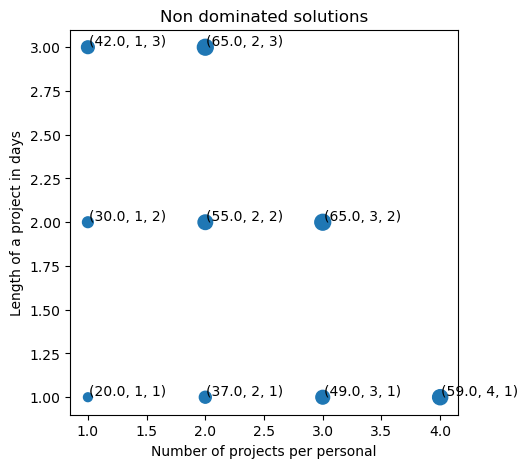

In [14]:
# plot a 3d scatter with the pareto list print the labels of each point and set a different color for each point
fig = plt.figure(figsize=(5,5))
# Create the scatter plot
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*2 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.01, i[2]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
plt.title("Non dominated solutions")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")

# Show the plot
plt.show()

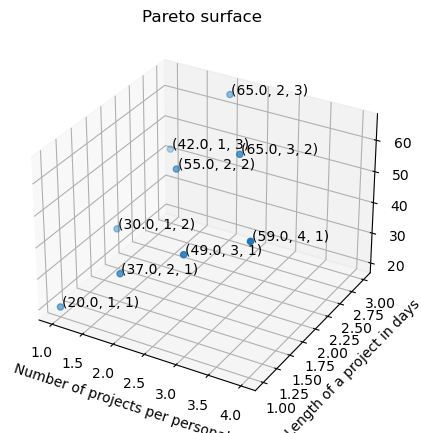

In [15]:
# Plot the pareto surface with the 3d scatter plot

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([i[1] for i in pareto], [i[2] for i in pareto], [i[0] for i in pareto])
for i in pareto:
    ax.text(i[1] + 0.01, i[2]+0.01, i[0]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
ax.set_xlabel('Number of projects per personal')
ax.set_ylabel('Length of a project in days')
ax.set_zlabel('Profit')
ax.set_title('Pareto surface')
plt.show()

# Preferences

## Weighted Sum

In [16]:
# create max dictionary with max values of each objective
max_dict = {0: max([i[0] for i in pareto]), 1: max([i[1] for i in pareto]), 2: max([i[2] for i in pareto])}

# somme pondérée des objectifs
def score(sol, w_1, w_2, w_3):
    return w_1*sol[0]/max_dict[0] + w_2*sol[1]/max_dict[1] + w_3*sol[2]/max_dict[2]

pareto_scores = [round(score(sol, 3, 2, 1.05), 2) for sol in pareto]

# pareto_sorted is a dictionary with the score as key and the solution as value ordered by score descending order
pareto_sorted = {pareto_scores[i]: pareto[i] for i in range(len(pareto_scores))}
pareto_sorted = dict(sorted(pareto_sorted.items(), reverse=True))
pareto_sorted

{5.2: (65.0, 3, 2),
 5.07: (59.0, 4, 1),
 5.05: (65.0, 2, 3),
 4.24: (55.0, 2, 2),
 4.11: (49.0, 3, 1),
 3.49: (42.0, 1, 3),
 3.06: (37.0, 2, 1),
 2.58: (30.0, 1, 2),
 1.77: (20.0, 1, 1)}

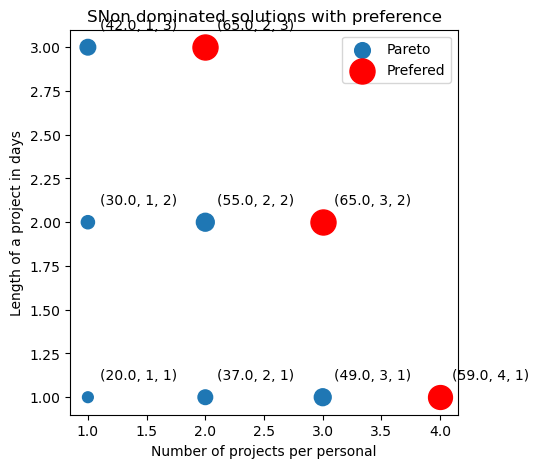

In [17]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto_sorted[list(pareto_sorted.keys())[i]][1]], [pareto_sorted[list(pareto_sorted.keys())[i]][2]],s = [pareto_sorted[list(pareto_sorted.keys())[i]][0]*5], color = 'red')

plt.title("SNon dominated solutions with preference")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()


## Bordas Rule

![](Capture%20d%E2%80%99%C3%A9cran%202023-02-09%20%C3%A0%2014.46.34.png)

In [18]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(59.0, -4, -1),
 (65.0, -3, -2),
 (49.0, -3, -1),
 (65.0, -2, -3),
 (55.0, -2, -2),
 (37.0, -2, -1),
 (42.0, -1, -3),
 (30.0, -1, -2),
 (20.0, -1, -1)]

In [19]:
# Borda Rule
# Rank all the solutions for each objective
# The best solution for each objective is ranked 1, the second best is ranked 2, etc.
# The sum of the ranks for each objective is the score for each solution
pareto1 = pareto.copy()
# Objective 1
pareto1.sort(key=lambda x: x[0], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = ([ind+1],val[0],val[1],val[2])
# Objective 2
pareto1.sort(key=lambda x: x[2], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])

# Objective 3
pareto1.sort(key=lambda x: x[3], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])
print(pareto1)

[([9, 3, 1], 20.0, -1, -1), ([7, 6, 2], 37.0, -2, -1), ([5, 8, 3], 49.0, -3, -1), ([3, 9, 4], 59.0, -4, -1), ([8, 2, 5], 30.0, -1, -2), ([4, 5, 6], 55.0, -2, -2), ([1, 7, 7], 65.0, -3, -2), ([6, 1, 8], 42.0, -1, -3), ([2, 4, 9], 65.0, -2, -3)]


In [20]:
# Sum the ranks for each solution
weights = [3,2,1]
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (sum(val[0][i]*weights[i] for i in range(3)),val[1],val[2],val[3])

# Sort the solutions by their score
pareto1.sort(key=lambda x: x[0], reverse=False)
pareto1

[(23, 65.0, -2, -3),
 (24, 65.0, -3, -2),
 (28, 55.0, -2, -2),
 (28, 42.0, -1, -3),
 (31, 59.0, -4, -1),
 (33, 30.0, -1, -2),
 (34, 20.0, -1, -1),
 (34, 49.0, -3, -1),
 (35, 37.0, -2, -1)]

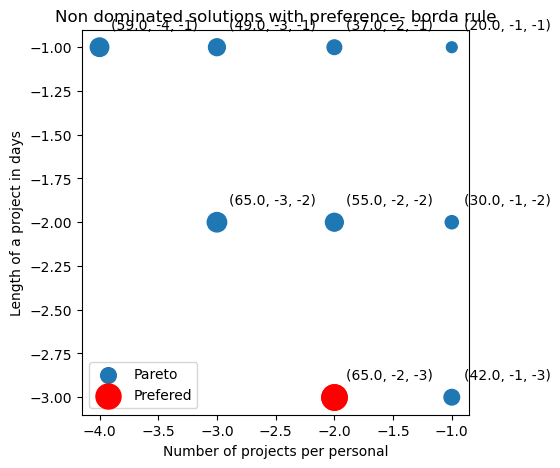

In [21]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto1[0][2]], [pareto1[0][3]],s = [pareto1[0][1]*5], color = 'red')

plt.title("Non dominated solutions with preference- borda rule")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()

## Split the solutions to 3 groups (First Try)

In [22]:
# From the 3 objectives, we want to split the solutions into 3 groups of solutions : unacceptable, acceptable and optimal
# We set limits for each objective to split the solutions into 3 groups
# The limits are the 25th and 75th percentiles of the maximum values of each objective
# The solutions that are below the 25th percentile are unacceptable
# The solutions that are between the 25th and 75th percentiles are acceptable
# The solutions that are above the 75th percentile are optimal


unacceptable = []
acceptable = []
optimal = []

# Split the solutions using the 3 objectives together

q1_obj1 = 0.5 * sum(gj.values())
q3_obj1 = 0.75 *sum(gj.values())
q1_obj2 = -0.75 * len(J)
q3_obj2 = -0.5 * len(J)
q1_obj3 = -0.75 * len(H)
q3_obj3 = -0.5 * len(H)
print(q1_obj1, q3_obj1, q1_obj2, q3_obj2, q1_obj3, q3_obj3)

for i in pareto:
    if i[0] <= q1_obj1 or i[1] <= q1_obj2 or i[2] <= q1_obj3:
        unacceptable.append(i)
    elif i[0] >= q3_obj1 and i[1] >= q3_obj2 and i[2] >= q3_obj3:
        optimal.append(i)
    else:
        acceptable.append(i)



print("Unacceptable solutions : ", unacceptable)
print("Acceptable solutions : ", acceptable)
print("Optimal solutions : ", optimal)




40.0 60.0 -3.75 -2.5 -3.75 -2.5
Unacceptable solutions :  [(59.0, -4, -1), (37.0, -2, -1), (30.0, -1, -2), (20.0, -1, -1)]
Acceptable solutions :  [(65.0, -3, -2), (49.0, -3, -1), (65.0, -2, -3), (55.0, -2, -2), (42.0, -1, -3)]
Optimal solutions :  []


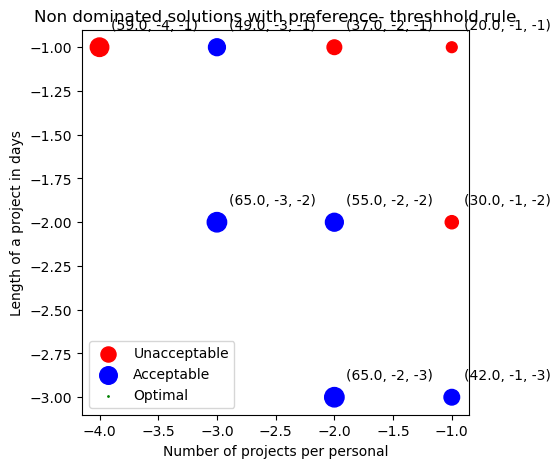

In [23]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in unacceptable], [i[2] for i in unacceptable],s = [i[0]*3 for i in unacceptable],color= 'r')
plt.scatter([i[1] for i in acceptable], [i[2] for i in acceptable],s = [i[0]*3 for i in acceptable], color = 'b')
plt.scatter([i[1] for i in optimal], [i[2] for i in optimal],s = [i[0]*3 for i in optimal], color = 'g')
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')



plt.title("Non dominated solutions with preference- threshhold rule")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Unacceptable', 'Acceptable','Optimal'])

# Show the plot
plt.show()

## Optimizing the weights and thresholds with Gurobi


In [24]:
non_dominated_solutions = pd.DataFrame(pareto, columns=['obj1', 'obj2', 'obj3'])
non_dominated_solutions.sort_values(by=['obj1'], ascending=False,inplace=True)
non_dominated_solutions

,obj1,obj2,obj3
1,65.0,-3,-2
3,65.0,-2,-3
0,59.0,-4,-1
4,55.0,-2,-2
2,49.0,-3,-1
6,42.0,-1,-3
5,37.0,-2,-1
7,30.0,-1,-2
8,20.0,-1,-1


In [25]:
from random import random, sample

def normalize_models(non_dominated_solutions,pareto):
    max_objVal = non_dominated_solutions["obj1"].max() # note
    max_duration = non_dominated_solutions["obj3"].max()
    max_assigned_jobs = non_dominated_solutions["obj2"].max()
    sols_normalized = []

    for sol in pareto:
        gain = sol[0] / max_objVal
        max_i =  sol[1] / max_assigned_jobs
        max_j =  sol[2] / max_duration
        sols_normalized.append((gain, max_i, max_j))

    return sols_normalized

# Générer des plannings aléatoires et les évaluer
def preference(pareto, sample_freq=None):
    
    inacceptable_models = []
    correct_models = []
    satisfying_models = []
    while (
        len(inacceptable_models) == 0
        or len(correct_models) == 0
        or len(satisfying_models) == 0
    ):
        w1, w2, w3,eps1,eps2 = get_random_weights()
        inacceptable_models = []
        correct_models = []
        satisfying_models = []

        for i in pareto:
            gain, max_i, max_j = i
            model_score = w1 * gain - w2 * max_i - w3 * max_j
            if model_score < eps1:
                inacceptable_models.append((gain, max_i, max_j))
            elif model_score < eps2:
                correct_models.append((gain, max_i, max_j))
            else:
                satisfying_models.append((gain, max_i, max_j))
    return inacceptable_models, correct_models, satisfying_models




def get_random_weights():
    w1 = random()
    w2 = random()
    w3 = random()

    w1=max(w1, w2, w3)
    somme=w1+w2+w3
    th1 = random()
    th2 = random()
    return w1/somme,max(w2,w3)/somme, min(w2,w3)/somme,min(th1, th2), max(th1, th2)




def find_pref_model(unacceptable, correct, satisfactory):
    model = grb.Model()

    # Define decision variables
    omega_1 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_1")
    omega_2 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_2")
    omega_3 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_3")
    th_1 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="th_1")
    th_2 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="th_2")
    eps = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="eps")

    # Add constraints
    model.addConstr(omega_1 + omega_2 + omega_3 == 1, name="normalisation")
    model.addConstr(omega_1 >= omega_2 , name="profit preferable to duration")
    model.addConstr(omega_2 >= omega_3 , name="number of projects preferable to duration")
    model.addConstr(eps <= th_1 , name="eps < th_1")
    model.addConstr(th_1 +eps<= th_2 , name="th1+eps < th_2")
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 <= th_1 - eps
            for (gain, max_i, max_j) in unacceptable),name="unacceptable_max", )
    
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 <= th_2 
            for (gain, max_i, max_j) in correct),name="correct_max",)

    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 >= th_1
            for (gain, max_i, max_j) in correct),name="correct_min",)
    
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 >= th_2 + eps
            for (gain, max_i, max_j) in satisfactory),name="satisfactory_min",)

    # Objective
    model.setObjective(eps, GRB.MAXIMIZE)
    model.setParam("OutputFlag", 0)
    try : 
        model.optimize()

        return omega_1.x, omega_2.x, omega_3.x, th_1.x, th_2.x, eps.x
    except:
        return 0,0,0,0,0,0


def order_solutions(pareto,non_dominated_solutions, params):
    w1, w2, w3 = params[:3]
    th1, th2,eps = params[3:]
    print("w1, w2, w3, th1, th2,eps", w1, w2, w3, th1, th2,eps)
    objVal = non_dominated_solutions['obj1'].values
    max_duration = non_dominated_solutions['obj3'].values
    max_assigned = non_dominated_solutions['obj2'].values
    normalized = normalize_models(non_dominated_solutions,pareto)
    score = [w1 * gain + w2 * max_i + w3 * max_j for (gain, max_i, max_j) in normalized]
    res = pd.DataFrame(
        {
            "objVal": objVal,
            "max_duration": max_duration,
            "max_assigned": max_assigned,
            "score": score,
        }
    )
    res = res.sort_values("score", ascending=False)
    res["status"] = res["score"].apply(
        lambda x: "unacceptable"
        if x < th1
        else ("correct" if x < th2 else "satisfactory")
    )

    return res, res[res['status'] == 'unacceptable'][['objVal', 'max_duration', 'max_assigned']].values.tolist(), res[res['status'] == 'correct'][['objVal', 'max_duration', 'max_assigned']].values.tolist(), res[res['status'] == 'satisfactory'][['objVal', 'max_duration', 'max_assigned']].values.tolist() 


normalized_surface =normalize_models(non_dominated_solutions,pareto)
unacceptable, correct, satisfactory = preference(
    normalized_surface, sample_freq=1.0
)
print("----------------------------------")
print("Unacceptable :",unacceptable, '\nCorrect :',correct, '\nSatisfactory :',satisfactory)
params = find_pref_model(unacceptable, correct, satisfactory)
#print(params)
print("----------------------------------")
print(order_solutions(pareto,non_dominated_solutions, params)[0])
unacceptable, correct, satisfactory  = order_solutions(pareto,non_dominated_solutions, params)[1:]



----------------------------------
Unacceptable : [(0.3076923076923077, 1.0, 1.0)] 
Correct : [(0.5692307692307692, 2.0, 1.0), (0.46153846153846156, 1.0, 2.0)] 
Satisfactory : [(0.9076923076923077, 4.0, 1.0), (1.0, 3.0, 2.0), (0.7538461538461538, 3.0, 1.0), (1.0, 2.0, 3.0), (0.8461538461538461, 2.0, 2.0), (0.6461538461538462, 1.0, 3.0)]
----------------------------------
w1, w2, w3, th1, th2,eps 0.5882352941176472 0.20588235294117643 0.20588235294117643 0.7963800904977375 1.0 0.2036199095022625
   objVal  max_duration  max_assigned     score        status
1    65.0            -3            -2  1.617647  satisfactory
3    55.0            -2            -2  1.617647  satisfactory
0    65.0            -2            -3  1.563348  satisfactory
4    49.0            -1            -3  1.321267  satisfactory
2    59.0            -1            -4  1.266968  satisfactory
6    37.0            -1            -2  1.203620  satisfactory
5    42.0            -3            -1  0.952489       correct
7   

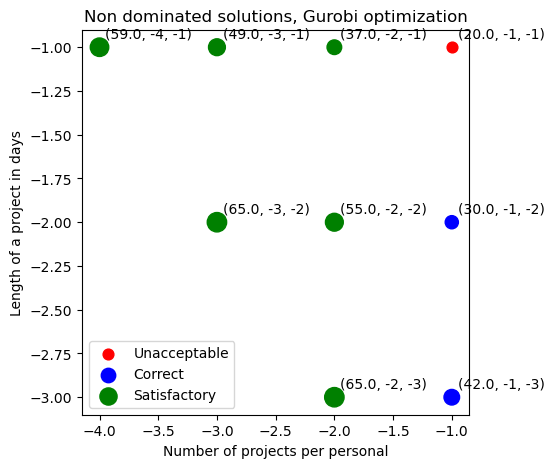

In [26]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[2] for i in unacceptable], [i[1] for i in unacceptable],s = [i[0]*3 for i in unacceptable],color= 'r')
plt.scatter([i[2] for i in correct], [i[1] for i in correct],s = [i[0]*3 for i in correct], color = 'b')
plt.scatter([i[2] for i in satisfactory], [i[1] for i in satisfactory],s = [i[0]*3 for i in satisfactory], color = 'g')
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.05, i[2]+0.05,  '%s' % (str(i)), size=10, zorder=1, color='k')



plt.title("Non dominated solutions, Gurobi optimization")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Unacceptable', 'Correct','Satisfactory'])

# Show the plot
plt.show()